In [1]:
#!pip install nibabel tqdm scikit-image

In [1]:
import os
import sys
import random
import math
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize
from scipy.ndimage import zoom

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D, Conv2DTranspose, Concatenate, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.autograd import Variable


from tensorflow.python.client import device_lib

In [2]:
#GPU 확인
print(tf.config.list_physical_devices('GPU'))
print(device_lib.list_local_devices())
tf.test.is_gpu_available()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1788283793429482032
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2914163099
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3882711060815096303
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
def image_normalization(img):
    x_min = np.min(img)
    if(x_min >=0.0):
        img = img - np.mean(img)
    return img

In [4]:
def get_mask_data():

    x_train_path = "dataset/x_train.npy"
    x_val_path = "dataset/x_val.npy" 
    y_train_path = "dataset/y_train.npy"
    y_val_path = "dataset/y_val.npy"
    
    x_train = np.load(x_train_path)
    x_val = np.load(x_val_path)
    y_train = np.load(y_train_path)
    y_val = np.load(y_val_path)

    print(x_train.shape, y_train.shape)
    print(x_val.shape, y_val.shape)
    
        
    return x_train, y_train, x_val, y_val


In [11]:
def mask_model(x_train, y_train, x_val, y_val) :
  
    inputs = Input(shape=(256, 256, 1))

    #down sampling 
    filters = 16
    kernel_size = 3
    copy_layers = []
    net = inputs
  
    for i in range(0, 6):
        net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
        net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
        copy_layers.append(net)
        net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
        filters = filters*2
    ff2 = 256
  
    #bottleneck 
    j = len(copy_layers) - 1
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    filters = filters/2
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]])
    net = BatchNormalization() (net)
    j = j -1 

    #upsampling 
    for i in range(0, 5):
        net = Conv2D(filters, 3, activation='relu', padding='same') (net)
        net = Conv2D(filters, 3, activation='relu', padding='same') (net)
        print(net.shape)
        filters = filters/2
        net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
        print(net.shape)
        net = Concatenate(axis=3)([net, copy_layers[j]])
        net = BatchNormalization() (net)
        j = j -1 
    
  
    #classification 
    net = Conv2D(filters, 3, activation='relu', padding='same') (net)
    net = Conv2D(filters, 3, activation='relu', padding='same') (net)
    outputs = Conv2D(1, 1, activation='sigmoid') (net)


    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

    model.summary()
    
    
    

    return model

In [6]:
def mask_model1(x_train, y_train, x_val, y_val) :
  
    inputs = Input(shape=(256, 256, 1))
    
    #down sampling 
    filters = 64
    kernel_size = 3
    copy_layers = []
    net = inputs
  
    net = Conv2D(filters, 3, activation='relu', padding='same') (net)
    net = Conv2D(filters, 3, activation='relu', padding='same') (net)
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    print(net.shape)
    
    filters = filters *2
    net = Conv2D(filters, 3, activation='relu', padding='same') (net)
    net = Conv2D(filters, 3, activation='relu', padding='same') (net)
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    print(net.shape)
    
    filters = filters *2
    net = Conv2D(filters, 3, activation='relu', padding='same') (net)
    net = Conv2D(filters, 3, activation='relu', padding='same') (net)
    net = Conv2D(filters, 3, activation='relu', padding='same') (net)
    net = Conv2D(filters, 3, activation='relu', padding='same') (net)
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    print(net.shape)
    
    filters = filters *2
    net = Conv2D(filters, 3, activation='relu', padding='same') (net)
    net = Conv2D(filters, 3, activation='relu', padding='same') (net)
    net = Conv2D(filters, 3, activation='relu', padding='same') (net)
    net = Conv2D(filters, 3, activation='relu', padding='same') (net)
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    print(net.shape)
    
    net = Conv2D(filters, 3, activation='relu', padding='same') (net)
    net = Conv2D(filters, 3, activation='relu', padding='same') (net)
    net = Conv2D(filters, 3, activation='relu', padding='same') (net)
    net = Conv2D(filters, 3, activation='relu', padding='same') (net)
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    print(net.shape)

#     net = Flatten() (net)
    print(net.shape)
    net = Dense(4096, activation = 'relu') (net)
    net = Dropout(0.5) (net)
    net = Dense(4096, activation = 'relu') (net)
    net = Dropout(0.5) (net)
    outputs = Dense(1000, activation = 'softmax') (net)
    

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc', 'mse'])

    model.summary()
    
    
    

    return model

In [7]:
def mask_model2(x_train, y_train, x_val, y_val) :
  
    inputs = Input(shape=(256, 256, 1))

    #down sampling 
    filters = 16
    kernel_size = 3
    copy_layers = []
    net = inputs
  
    #16
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    copy_layers.append(net)
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #32
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    copy_layers.append(net)
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #64
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    copy_layers.append(net)
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #128
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    copy_layers.append(net)
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    
    #128
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    copy_layers.append(net)
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    
    #128
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    #upsampling
    
    j = len(copy_layers) - 1
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]])
    
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    j = j -1 

    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]])
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)

    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]])
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)

    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]])
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]])
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    outputs = Conv2D(1, 1, activation='sigmoid') (net)




    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

    model.summary()
    
    
    

    return model

In [8]:
def training_model(model,x_train, y_train, x_val, y_val) :
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30, batch_size=16, 
                      callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)])
    fig, ax = plt.subplots(3, 2, figsize=(10, 7))
    plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.35)

    ax[0, 0].set_title('loss')
    ax[0, 0].plot(history.history['loss'], 'r')
    ax[0, 1].set_title('acc')
    ax[0, 1].plot(history.history['acc'], 'b')

    ax[1, 0].set_title('val_loss')
    ax[1, 0].plot(history.history['val_loss'], 'r--')
    ax[1, 1].set_title('val_acc')
    ax[1, 1].plot(history.history['val_acc'], 'b--')
    
#     ax[2,0].set_title('MeanIoU')
#     ax[2,0].plot(history.history['mean_io_u_67'], 'r')
#     ax[2,1].set_title('val_MeanIoU')
#     ax[2,1].plot(history.history['val_mean_io_u_67'], 'r')

    preds = model.predict(x_val)

    fig, ax = plt.subplots(40, 4, figsize=(10, 100))
    
    temp = np.empty((256, 256, 1), dtype=np.float32)

    for i in range(40):
        ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
        ax[i, 0].title.set_text(str(i))
        ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
        ax[i, 2].imshow(preds[i].squeeze(), cmap='gray')
        temp = x_val[i]
        pred_sum = preds[i][preds[i] > 0]
        pred_mean = np.mean(pred_sum)
        if(np.min(temp) >= 0) :
            temp[preds[i] < pred_mean] = 0
        else :
            temp[preds[i] < pred_mean] = -2048
        ax[i, 3].imshow(temp.squeeze(), cmap='gray')


(2675, 256, 256, 1) (2675, 256, 256, 1)
(298, 256, 256, 1) (298, 256, 256, 1)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_76 (Conv2D)              (None, 256, 256, 16) 160         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 256, 256, 16) 2320        conv2d_76[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 128, 128, 16) 0           conv2d_77[0][0]                  
______________

168/168 [==============================] - 106s 540ms/step - loss: 0.4569 - acc: 0.8234 - val_loss: 0.2207 - val_acc: 0.8674
Epoch 2/30
168/168 [==============================] - 86s 510ms/step - loss: 0.1177 - acc: 0.8675 - val_loss: 0.0392 - val_acc: 0.8674
Epoch 3/30
168/168 [==============================] - 86s 514ms/step - loss: 0.0183 - acc: 0.8675 - val_loss: 0.0078 - val_acc: 0.8674
Epoch 4/30
168/168 [==============================] - 86s 514ms/step - loss: 0.0070 - acc: 0.8675 - val_loss: 0.0091 - val_acc: 0.8674
Epoch 5/30
168/168 [==============================] - 86s 515ms/step - loss: 0.0064 - acc: 0.8675 - val_loss: 0.0065 - val_acc: 0.8674
Epoch 6/30
168/168 [==============================] - 87s 518ms/step - loss: 0.0063 - acc: 0.8675 - val_loss: 0.0062 - val_acc: 0.8674
Epoch 7/30
168/168 [==============================] - 85s 507ms/step - loss: 0.0062 - acc: 0.8675 - val_loss: 0.0062 - val_acc: 0.8674
Epoch 8/30
168/168 [==============================] - 86s 509ms/s

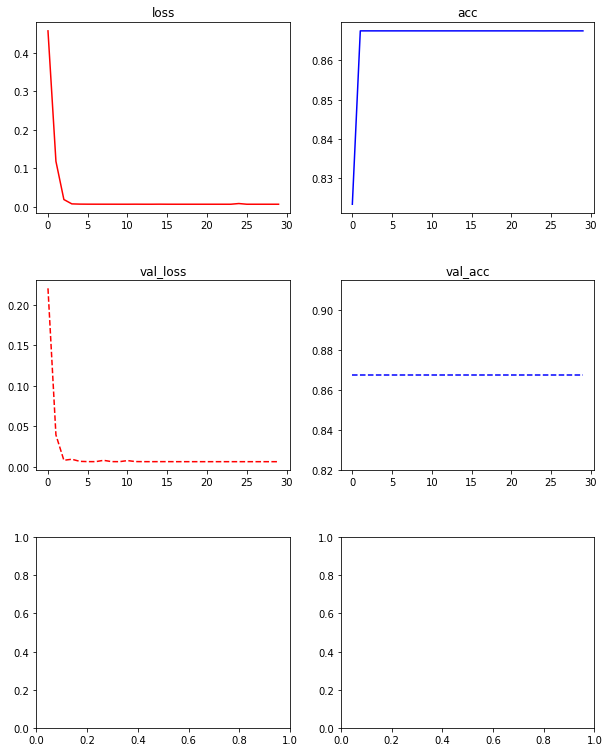

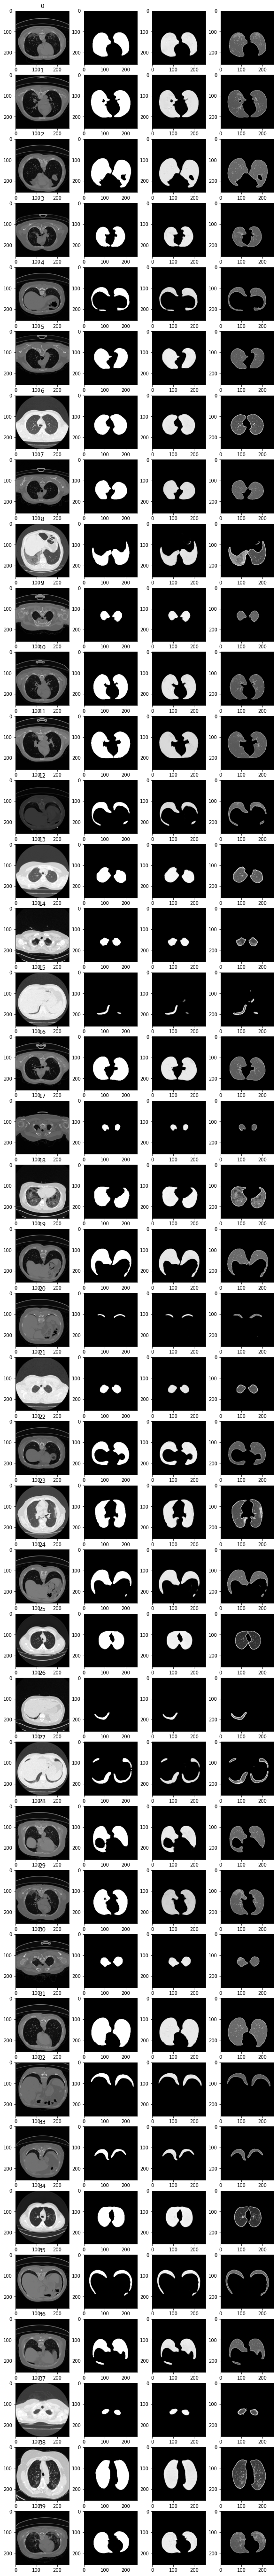

In [16]:
x_train, y_train, x_val, y_val = get_mask_data()
model = mask_model2(x_train, y_train, x_val, y_val)
history = training_model(model,x_train, y_train, x_val, y_val)

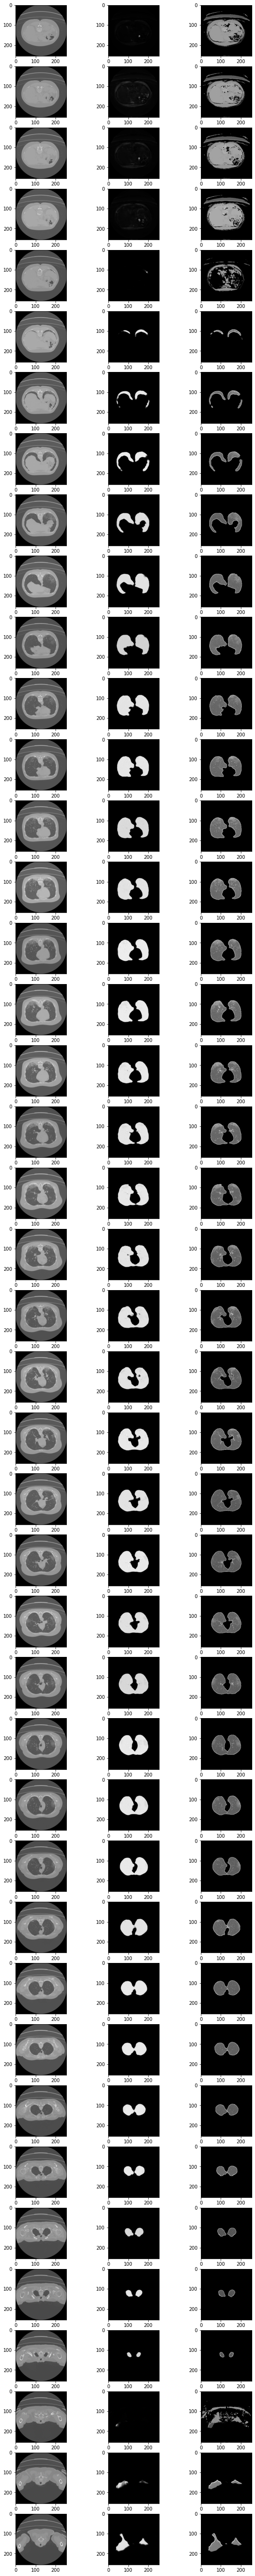

In [17]:
test_name = "study_1110.nii.gz"
test_data = nib.load(test_name)

test_array = np.array(test_data.get_fdata(), dtype=np.float32)
test_array = test_array.T

test = np.empty(( len(test_array),256,256, 1), dtype=np.float32)

for i,img in enumerate(test_array):
    image = resize(img, output_shape=(256, 256, 1), preserve_range=True)
#     img_sum = image[image > -2048]
#     img_mean = np.mean(img_sum)
#     image[image < -1000] = -2048
    test[i] = image



preds=model.predict(test)


fig, ax = plt.subplots(len(preds), 3, figsize=(10, 100))
temp = np.empty((256, 256, 1), dtype=np.float32)

for i, pred in enumerate(preds):
    ax[i,0].imshow(test[i].squeeze(), cmap = "gray")
    ax[i,1].imshow(pred.squeeze(), cmap = "gray")
    temp = test[i]
    pred_sum = pred[pred > 0]
    pred_mean = np.mean(pred_sum)
    if(np.min(temp) >= 0) :
        temp[pred < pred_mean] = 0
    else :
        temp[pred < pred_mean] = -2048
    ax[i, 2].imshow(temp.squeeze(), cmap='gray')
    


(2675, 256, 256, 1) (2675, 256, 256, 1)
(298, 256, 256, 1) (298, 256, 256, 1)
(None, 8, 8, 512)
(None, 16, 16, 256)
(None, 16, 16, 256)
(None, 32, 32, 128)
(None, 32, 32, 128)
(None, 64, 64, 64)
(None, 64, 64, 64)
(None, 128, 128, 32)
(None, 128, 128, 32)
(None, 256, 256, 16)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 256, 256, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 256, 256, 16) 2320        conv2d_27[0][0]                  
_____________

168/168 [==============================] - 92s 519ms/step - loss: 0.0270 - acc: 0.8620 - val_loss: 0.0340 - val_acc: 0.8674
Epoch 2/30
168/168 [==============================] - 86s 513ms/step - loss: 0.0066 - acc: 0.8675 - val_loss: 0.0091 - val_acc: 0.8674
Epoch 3/30
168/168 [==============================] - 87s 520ms/step - loss: 0.0063 - acc: 0.8675 - val_loss: 0.0092 - val_acc: 0.8674
Epoch 4/30
168/168 [==============================] - 87s 518ms/step - loss: 0.0063 - acc: 0.8675 - val_loss: 0.0064 - val_acc: 0.8674
Epoch 5/30
168/168 [==============================] - 86s 515ms/step - loss: 0.0062 - acc: 0.8675 - val_loss: 0.0091 - val_acc: 0.8674
Epoch 6/30
168/168 [==============================] - 87s 519ms/step - loss: 0.0062 - acc: 0.8675 - val_loss: 0.0062 - val_acc: 0.8674
Epoch 7/30
168/168 [==============================] - 87s 520ms/step - loss: 0.0062 - acc: 0.8675 - val_loss: 0.0079 - val_acc: 0.8674
Epoch 8/30
168/168 [==============================] - 87s 518ms/st

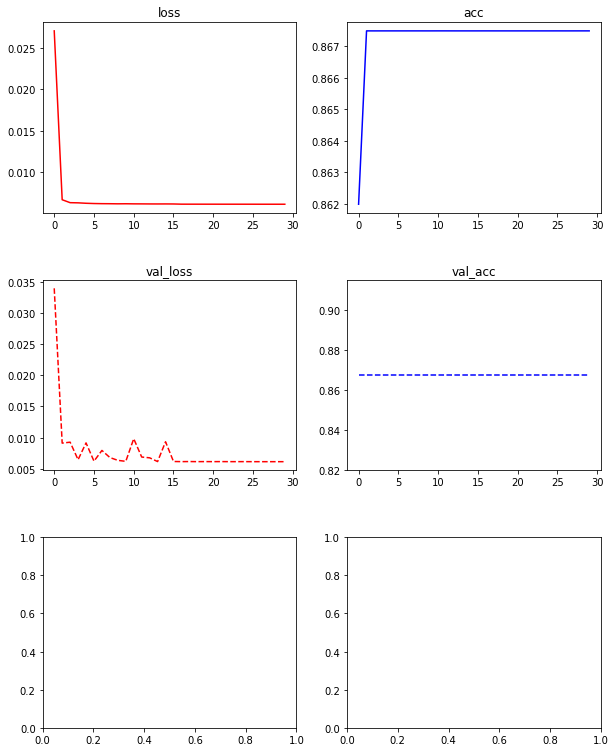

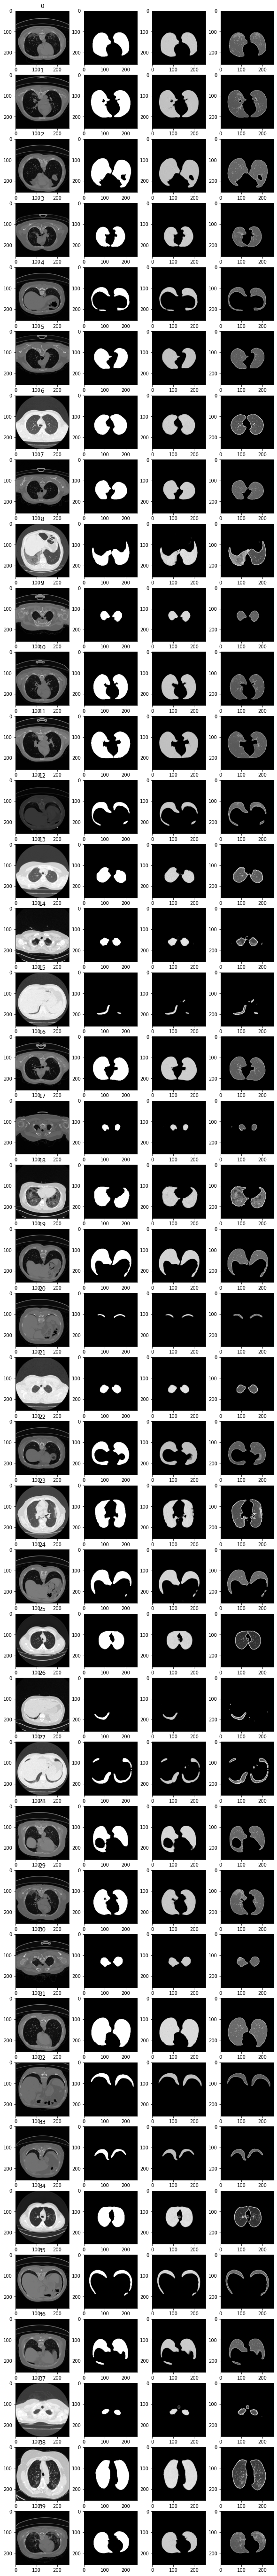

In [12]:
x_train1, y_train1, x_val1, y_val1 = get_mask_data()
model1 = mask_model(x_train1, y_train1, x_val1, y_val1)
history1 = training_model(model1,x_train1, y_train1, x_val1, y_val1)

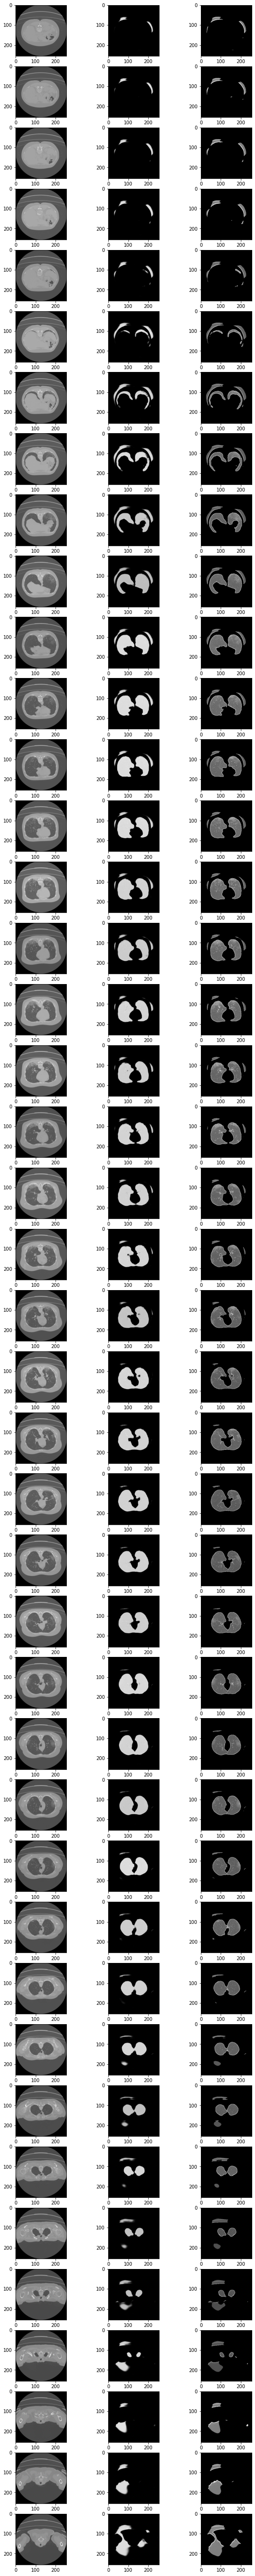

In [13]:
test_name1 = "study_1110.nii.gz"
test_data1 = nib.load(test_name1)

test_array1 = np.array(test_data1.get_fdata(), dtype=np.float32)
test_array1 = test_array1.T

test1 = np.empty(( len(test_array1),256,256, 1), dtype=np.float32)

for i,img1 in enumerate(test_array1):
    image1 = resize(img1, output_shape=(256, 256, 1), preserve_range=True)
#     img_sum = image[image > -2048]
#     img_mean = np.mean(img_sum)
#     image[image < -1000] = -2048
    test1[i] = image1



preds1=model1.predict(test1)


fig1, ax1 = plt.subplots(len(preds1), 3, figsize=(10, 100))
temp1 = np.empty((256, 256, 1), dtype=np.float32)

for i, pred1 in enumerate(preds1):
    ax1[i,0].imshow(test1[i].squeeze(), cmap = "gray")
    ax1[i,1].imshow(pred1.squeeze(), cmap = "gray")
    temp1 = test1[i]
    pred_sum1 = pred1[pred1 > 0]
    pred_mean1 = np.mean(pred_sum1)
    if(np.min(temp1) >= 0) :
        temp1[pred1 < pred_mean1] = 0
    else :
        temp1[pred1 < pred_mean1] = -2048
    ax1[i, 2].imshow(temp1.squeeze(), cmap='gray')
    